In [230]:
# Use the Azure Machine Learning data preparation package
from azureml.dataprep import package

# Use the Azure Machine Learning data collector to log various metrics
from azureml.logging import get_azureml_logger
logger = get_azureml_logger()


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

do_grid_search_cv = False

In [231]:
# Use Azure Machine Learning history magic to control history collection
# History is off by default, options are "on", "off", or "show"
# %azureml history on


In [232]:
# This call will load the referenced package and return a DataFrame.
# If run in a PySpark environment, this call returns a
# Spark DataFrame. If not, it returns a Pandas DataFrame.
features = package.run('dprep1.dprep', dataflow_idx=2)
submission_test_data = package.run('dprep1.dprep', dataflow_idx=3)

feature_names = features.columns.get_values()

In [233]:
features.head(3)

,area_is_metro,is_recreation_dependent,is_mining_or_manufacturing_dependent,econ__pct_civilian_labor,econ__pct_unemployment,econ__pct_uninsured_adults,econ__pct_uninsured_children,demo__pct_female,demo__pct_below_18_years_of_age,demo__pct_aged_65_years_and_older,...,health__pct_adult_smoking,health__pct_diabetes,health__pct_low_birthweight,health__pct_excessive_drinking,health__pct_physical_inacticity,health__air_pollution_particulate_matter,health__pop_per_dentist,health__pop_per_primary_care_physician,is_yr_a,heart_disease_mortality_per_100k
0,True,False,True,0.408,0.057,0.254,0.066,0.516,0.235,0.176,...,0.230,0.131,0.089,NaN,0.332,13.0,1650.0,1489.0,True,312.0
1,True,False,True,0.556,0.039,0.260,0.143,0.503,0.272,0.101,...,0.190,0.090,0.082,0.181,0.265,10.0,2010.0,2480.0,True,257.0
2,True,False,False,0.541,0.057,0.070,0.023,0.522,0.179,0.115,...,0.156,0.084,0.098,0.195,0.209,10.0,629.0,690.0,False,195.0


In [234]:
submission_test_data.head(3)

,row_id,area_is_metro,is_recreation_dependent,is_mining_or_manufacturing_dependent,econ__pct_civilian_labor,econ__pct_unemployment,econ__pct_uninsured_adults,econ__pct_uninsured_children,demo__pct_female,demo__pct_below_18_years_of_age,...,health__pct_adult_obesity,health__pct_adult_smoking,health__pct_diabetes,health__pct_low_birthweight,health__pct_excessive_drinking,health__pct_physical_inacticity,health__air_pollution_particulate_matter,health__pop_per_dentist,health__pop_per_primary_care_physician,is_yr_a
0,2.0,False,True,False,0.469,0.070,0.211,0.156,0.499,0.184,...,0.217,0.166,0.078,0.079,0.217,0.162,11.0,1569.0,1559.0,True
1,3.0,True,False,False,0.509,0.061,0.182,0.056,0.514,0.211,...,0.283,0.172,0.099,0.078,0.183,0.269,10.0,1709.0,1069.0,True
2,7.0,True,False,False,0.479,0.042,0.294,0.131,0.514,0.245,...,0.288,0.184,0.094,0.078,0.105,0.275,10.0,1789.0,1990.0,True


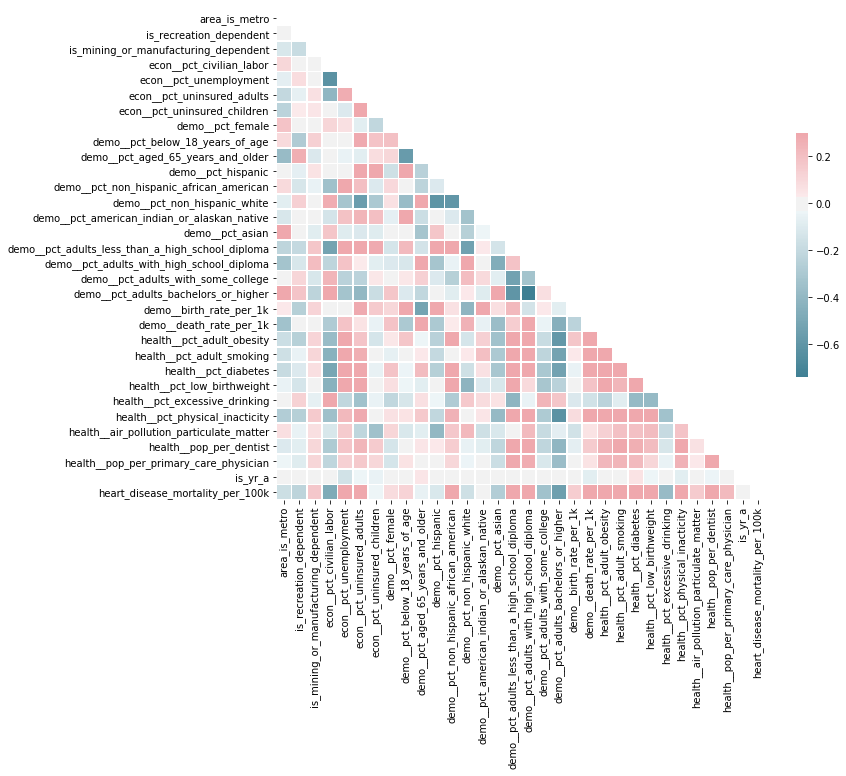

In [235]:
dff = features #[['health__pct_adult_smoking', 'health__pct_excessive_drinking', 'demo__death_rate_per_1k']]


# Compute the correlation matrix
corr = dff.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [236]:
# select just a few predictors
#predictors = ['health__pct_physical_inacticity', 'health__pct_diabetes', 'econ__pct_civilian_labor',
#             'demo__pct_adults_less_than_a_high_school_diploma', 'demo__pct_adults_bachelors_or_higher']
#
#features = features[predictors + ['heart_disease_mortality_per_100k']]
#submission_test_data = submission_test_data[predictors]

In [237]:
features = features.fillna(features.mean())
submission_test_data = submission_test_data.fillna(submission_test_data.mean())

In [238]:
# Labels are the values we want to predict
labels = np.array(features['heart_disease_mortality_per_100k'])

# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('heart_disease_mortality_per_100k', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [239]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [240]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (2398, 31)
Training Labels Shape: (2398,)
Testing Features Shape: (800, 31)
Testing Labels Shape: (800,)


In [241]:
# Import the model we are using
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


# Create the parameter grid based on the results of random search 
rf_param_grid = {
    'bootstrap': [True],
    'oob_score': [False],
    'max_depth': [80, 95, 110],
    'max_features': ['auto','sqrt','log2'],
    'min_samples_leaf': [5, 20, 35],
    'min_samples_split': [2, 16, 32],
    'n_estimators': [500, 1000]
}

# Linreg as baseline
lreg = LinearRegression()

# Train the model on training data
lreg.fit(train_features, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [242]:
# Train random forest

rf = RandomForestRegressor(
    bootstrap= True,
    criterion= 'mse',
    max_depth= 95,
    max_features= 'auto',
    max_leaf_nodes= None,
    min_impurity_split= 1e-07,
    min_samples_leaf= 5,
    min_samples_split= 2,
    min_weight_fraction_leaf= 0.0,
    n_estimators= 1000,
    n_jobs= -1,
    oob_score= False,
    random_state= None,
    verbose= 0,
    warm_start= False
)

if do_grid_search_cv:
    # Instantiate the grid search model
    rf_grid_search = GridSearchCV(estimator = rf, param_grid = rf_param_grid, 
                          cv = 6, n_jobs = -1, verbose = 2)
    rf_grid_search.fit(train_features, train_labels)
    rf = rf_grid_search.best_estimator_
    rf.get_params()

# Fit the model on all the training data
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=95,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [243]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Use the model's predict method on the test data
predictions = rf.predict(test_features)

rmse = sqrt(mean_squared_error(test_labels, predictions))

# Print out the rmse
print('RMSE Random Forest:', round(np.mean(rmse), 2))


predictions = lreg.predict(test_features)

rmse = sqrt(mean_squared_error(test_labels, predictions))

# Print out the rmse
print('RMSE Linear Regression:', round(np.mean(rmse), 2))

RMSE Random Forest: 32.66
RMSE Linear Regression: 34.38


In [244]:
# predict on the submission test data
row_ids = np.array(submission_test_data['row_id'])

submission_test_data = submission_test_data.drop('row_id', axis = 1)

submission_predictions = rf.predict(submission_test_data)

output = pd.DataFrame({'row_id': row_ids, 'heart_disease_mortality_per_100k': submission_predictions}).astype('int32')

In [245]:
output.astype('int32').to_csv('submission.csv', columns=['row_id','heart_disease_mortality_per_100k'], index=False)

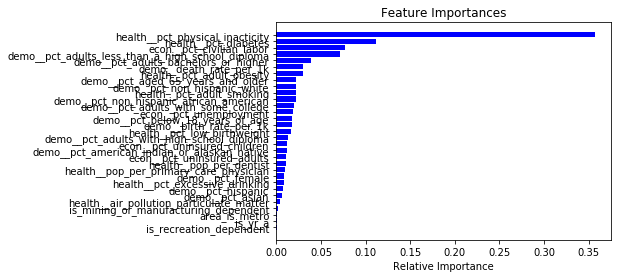

In [246]:
importances = rf.feature_importances_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [249]:
importances

array([ 0.00087065,  0.00067077,  0.00188821,  0.07646965,  0.01818484,
        0.0111954 ,  0.01201909,  0.00848267,  0.01748406,  0.02241421,
        0.00719152,  0.02176837,  0.02194847,  0.01160166,  0.00656033,
        0.0708918 ,  0.01328019,  0.02031146,  0.03904011,  0.01719943,
        0.02973238,  0.02949785,  0.02191481,  0.11180855,  0.01683264,
        0.00845796,  0.35726302,  0.00398442,  0.01029306,  0.01006648,
        0.00067595])